In [1]:
%matplotlib inline
from functools import partial, reduce
from pathlib import Path
import missingno as msno
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

route = Path.home() / "OneDrive" / "PhD Dissertation" / "Data_Code" / "Data"
if not route.exists():
    route.mkdir(parents=True)

df_final = pd.read_csv(
    Path.home() / "OneDrive" / "Rawdata" / "Data cleaning" / "df_final.csv"
).set_index(["Numeric", "Year"])
df_final["Official exchange rate (LCU per US$, period average)_pct_change"] = df_final[
    "Official exchange rate (LCU per US$, period average)"
].pct_change()

df_final["sdg3_hiv_pct_change"] = df_final["sdg3_hiv"].pct_change()
df_final["Red List Index_diff"] = df_final["Red List Index"].diff()
df_final["NOx emissions [Gg]_per_capita"] = df_final["NOx emissions [Gg]"]/df_final["Population, total"]

df_final["Methane emissions (kt of CO2 equivalent)_per_capita"] = df_final["Methane emissions (kt of CO2 equivalent)"]/df_final["Population, total"]

df_final["Black Carbon Emissions_per_capita"] = df_final["Black Carbon Emissions"]/df_final["Population, total"]
df_final = df_final.sort_index()

/var/folders/dc/cbvy15k16vz7s8mls82v1ng80000gn/T/ipykernel_35134/2646565027.py:13: DtypeWarning: Columns (1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1504,1580,1581,1583,1585,2210,2212,2227,2228,2229,2230,2233,2234,2235,2236,2239,2240,2241,2242,2262,2263,2264,2268,2269,2270,2271,2272,2273,2274,2275,2289,2290,2291,2292,2357,2367,2369,2371,2372,2375,2428) have mixed types. Specify dtype option on import or set low_memory=False.
  df_final = pd.read_csv(


<Axes: >

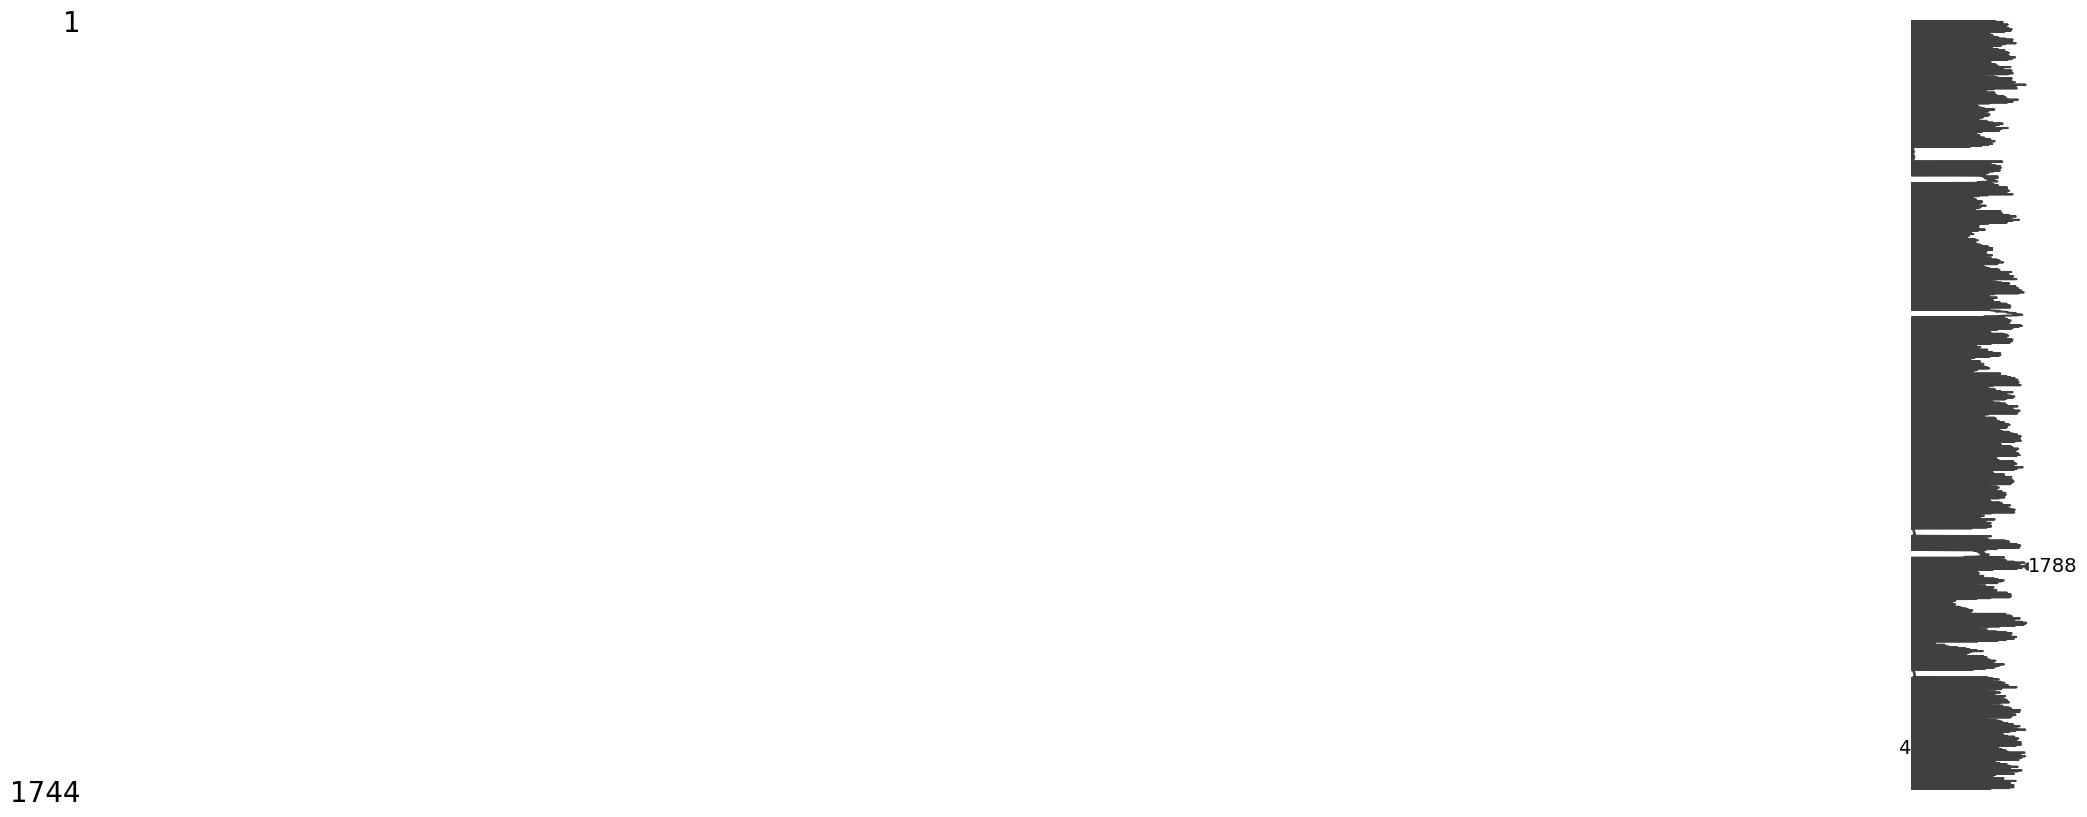

In [6]:
msno.matrix(df_final.loc[(slice(None), range(2005, 2021)),])

In [3]:
##Compute which variables can be used
years = list(range(2005, 2021))
variables = (
    df_final.query("Year in @years")
    .groupby("Numeric")
    .agg("count")
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={0: "count"})
)
variables["count"] = variables["count"] / len(years)
variables = variables.query("count>40")

##Add the Chinese names for the variables
if (route / "Variables Selection" / "WDI_CN.xlsx").exists():
    variables = (
        pd.read_excel(route / "Variables Selection" / "WDI_CN.xlsx")[
            ["Indicator Name", "Chinese"]
        ]
        .rename(columns={"Indicator Name": "index"})
        .merge(variables, how="right", on=["index"])
    )
variables.to_excel(route / "Variables Count.xlsx", index=False)

In [4]:
###Filter the data
# Get variables and country names
VARIABLES = pd.read_excel(
    route / "Variables Selection" / "Variables Chosen.xlsx",
    sheet_name="Sheet2",
    na_values="..",
)

country = pd.read_excel(
    route / "Variables Selection" / "Variables Chosen.xlsx",
    sheet_name="Countries",
    na_values="..",
)

In [5]:
data_raw = (
    df_final[VARIABLES["Variables"]]
    .reset_index()
    .merge(country[["Numeric", "Alpha-3 code", "CountryName_CN"]], on="Numeric")
    .rename(columns={"Alpha-3 code_y": "Alpha-3 code"})
)

data_filtered = data_raw.copy().query("Year >= 2005 and Year <= 2020")


indices_threshold = {
    "GNI per capita (constant 2015 US$)": 11,
    "External debt stocks (% of GNI)": 11,
    "Incidence of malaria (per 1,000 population at risk)_y": 11,
    "Average Total Years of Schooling for Adult Population": 11,
    "Current account balance (% of GDP)": 11,
    "Prevalence of HIV, total (% of population ages 15-49)":11,
    "Prevalence of undernourishment (% of population)":11,
}
for index, threshold in indices_threshold.items():
    result = data_filtered.groupby("Numeric")[index].count() < threshold
    indices = result.loc[result].index
    data_filtered = data_filtered.query("Numeric not in @indices")


data_filtered.to_excel(route / "raw_data.xlsx", index=False)

In [6]:
print(len(data_filtered["Numeric"].unique()))

data_filtered.loc[:, data_filtered.isnull().any()].isnull().sum().sort_values()

22


Services, value added (% of GDP)                                                                   1
Industry (including construction), value added (% of GDP)                                          2
Mobile cellular subscriptions (per 100 people)                                                     2
GNI per capita (constant 2015 US$)                                                                 7
Current account balance (% of GDP)                                                                 9
Unsafe drinking water                                                                             22
NOE                                                                                               22
SOE                                                                                               22
Lead exposure                                                                                     22
Average proportion of Terrestrial Key Biodiversity Areas (KBAs) covered by protected areas 

In [7]:
from pandas.api.types import is_numeric_dtype


def interpolate_with_linear_regression(df):
    df = df.copy()
    for col in df.columns:
        if col in ("Numeric", "Year"):
            continue
        if df[col].isna().values.any():
            na_mask = df[col].isna()
            if col in ("NOE", "SOE", "Lead exposure"):
                lin_reg = LinearRegression()
                lin_reg.fit(df.loc[~na_mask, ("CO2 emissions (metric tons per capita)","Year")], df.loc[~na_mask, col])
                pred = lin_reg.predict(df.loc[na_mask, ("CO2 emissions (metric tons per capita)","Year")])
            else:
                if (~na_mask).sum() < 5:
                    print(
                        f"Country {df['Numeric'].iloc[0]:.0f} '{col}' has less than 5 values, skip interpolation."
                    )
                    continue
                if not is_numeric_dtype(df[col]):
                    print(
                        f"Country {df['Numeric'].iloc[0]:.0f} '{col}' is not numeric dtype, skip interpolation."
                    )
                    continue
                lin_reg = LinearRegression()
                lin_reg.fit(df.loc[~na_mask, ("Year",)], df.loc[~na_mask, col])
                pred = lin_reg.predict(df.loc[na_mask, ("Year",)])
            df.loc[na_mask, col] = pred
    return df


data_filled = data_filtered.groupby("Numeric", group_keys=True).apply(
    interpolate_with_linear_regression
)  # .dropna(axis=1)


data_filled.to_excel(route / "data_filled.xlsx", index=True)
data_filled

Numeric  Year  GDP growth (annual %)  \
Numeric                                             
24      45        24  2005              15.030000   
        46        24  2006              11.550000   
        47        24  2007              14.010000   
        48        24  2008              11.170000   
        49        24  2009               0.860000   
...              ...   ...                    ...   
854     875      854  2016               5.957977   
        876      854  2017               6.203489   
        877      854  2018               6.604569   
        878      854  2019               5.688115   
        879      854  2020               1.930325   

             GDP per capita growth (annual %)  \
Numeric                                         
24      45                          11.009566   
        46                           7.614219   
        47                           9.935109   
        48                           7.163046   
        49                          -2.797290   
...                                       ...   
854     875                          2.893498   
        876                          3.203257   
        877                          3.693513   
        878                          2.868728   
        879                         -0.773847   

             GNI per capita (constant 2015 US$)  \
Numeric                                           
24      45                          2089.359899   
        46                          2198.593832   
        47                          2465.723255   
        48                          2517.747627   
        49                          2716.266819   
...                                         ...   
854     875                          620.883001   
        876                          645.475284   
        877                          673.454670   
        878                          675.849102   
        879                          682.172721   

             Industry (including construction), value added (% of GDP)  \
Numeric                                                                  
24      45                                           60.401993           
        46                                           58.109331           
        47                                           61.883538           
        48                                           60.254820           
        49                                           44.056374           
...                                                        ...           
854     875                                          24.881517           
        876                                          25.140237           
        877                                          25.589443           
        878                                          27.147494           
        879                                          32.591325           

             Services, value added (% of GDP)  \
Numeric                                         
24      45                          35.526726   
        46                          37.156847   
        47                          34.611878   
        48                          34.338202   
        49                          48.990671   
...                                       ...   
854     875                         43.805827   
        876                         43.967984   
        877                         43.550813   
        878                         44.870753   
        879                         40.826091   

             Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate)  \
Numeric                                                                                             
24      45                                               8.803                                      
        46                                               8.758                                      
        47      

In [8]:
print(len(data_filled["Numeric"].unique()))

data_filled.loc[:, data_filled.isnull().any()].isnull().sum().sort_values()

22


Series([], dtype: float64)

In [9]:
### Calculate coefficient of variance
from functools import partial

from scipy.stats import variation

data_CV = data_filled.set_index(["Alpha-3 code", "Numeric", "Year", "CountryName_CN"])
coefva = (
    pd.DataFrame(data_CV.apply(partial(variation, ddof=1)))
    .abs()
    .rename(columns={0: "coefva"})
)
small_coefva = coefva.query("coefva < 0.25").index
data_CV = data_filled[[col for col in data_filled.columns if col not in small_coefva]]
variables_post_cv = [
    col
    for col in data_filled.columns
    if col not in small_coefva
    if col
    not in [
        "Numeric",
        "Year",
        "Alpha-3 code",
        "CountryName_CN",
        "Region",
        "incomegroup",
    ]
]
(
    VARIABLES.query(
        '类型 in ["正向", "负向"] and 变量类型 == "指标体系" and Variables in @variables_post_cv'
    )
    .set_index(["一级指标", "二级指标", "三级指标"])
    .drop(columns=["变量类型"])
    .apply(lambda x: np.abs(variation(data_CV[x["Variables"]], ddof=1)), axis=1)
    .to_frame()
)

0
一级指标 二级指标   三级指标                                      
经济增长 经济发展质量 GDP年增长率（%）                        1.045566
            人均GDP增长率（%）                       2.702928
            人均GNI（2015不变价美元）                  0.883068
            工业增加值占GDP百分比（%）                   0.466026
     经济稳定指数 青年失业率                             0.946183
            按GDP平减的年通货膨胀率（%）                  1.160527
            官方汇率变化率（每美元本地货币）                  2.232738
     公共财政   经常账户余额                            1.966048
            外债存量（占GNI百分比）（%）                  0.660489
社会进步 人口状况   营养不良发生率(%)                        0.598922
            65岁以上人口比例                         1.392787
            人口增长率                             0.293898
     医疗教育   平均受教育年限                           0.406572
            教育投入                              0.471103
            疟疾感染                              0.747154
            肺结核感染率                            0.986798
            艾滋病感染率                            1.479040
     基础设施   不安全的饮用水                           0.502595
            每百人拥有手机数量                         0.570609
            通电率（占人口百分比）                       0.500910
环境支持 环境污染   人均碳排放                             1.895470
            氮氧化合物暴露                           0.994911
            二氧化硫暴露                            2.216235
            铅暴露                               0.301841
     环境治理   陆地生物群落保护(全球权重)                    0.426653
            被保护区覆盖的陆地生物多样性重点区平均比例(%)          0.455716
自然资源 自然资源属性 森林面积（占土地面积的百分比）                   0.556889
            可耕地面积（占土地面积的百分比）                  0.835741
            石油储备量                             3.509539
            人均可再生内陆淡水资源(立方米)                  1.697187
     能源消费   能源损耗（占GNI百分比）                     2.647607
            可再生能源消耗(占最终总能源消耗的%)               0.356722
            每单位GDP的二氧化碳排放                     0.788511
     资源利用   一次能源的能源强度水平(MJ/ 2017年美元购买力平价GDP)  0.503046
            水资源生产效率                           1.241544

In [10]:
small_coefva

Index(['Services, value added (% of GDP)', 'gini',
       'Life expectancy at birth, total (years)', 'Red List Index'],
      dtype='object')

In [11]:
### Calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor


def drop_according_VIF(variables):
    df = data_CV[list(set(data_CV.columns) & set(variables["Variables"]))]
    vif = pd.DataFrame()
    vif["Variables"] = df.columns
    vif["VIF"] = np.nan
    if df.shape[1] >= 2:
        vif["VIF"] = [
            variance_inflation_factor(df.values, i) for i in range(df.shape[1])
        ]
        max_vif = vif.loc[vif["VIF"].idxmax()]
        if max_vif["VIF"] > 10:
            print(
                f"Drop variable '{max_vif['Variables']}' with VIF {max_vif['VIF']:.2f}"
            )
            variables = drop_according_VIF(
                variables[variables["Variables"] != max_vif["Variables"]]
            )
    return variables


def calculate_VIF(row):
    variables = VARIABLES[
        np.logical_and(
            VARIABLES["一级指标"] == row["一级指标"],
            VARIABLES["Variables"].isin(variables_post_VIF),
        )
    ]["Variables"].tolist()
    if len(variables) >= 2:
        var = row["Variables"]
        var_index = variables.index(var)
        return variance_inflation_factor(data_filled[variables].values, var_index)
    else:
        return np.nan


variables_post_VIF = list(
    VARIABLES.query(
        '类型 in ["正向", "负向"] and 变量类型 == "指标体系" and Variables in @variables_post_cv'
    )
    .groupby("一级指标", group_keys=False)
    .apply(drop_according_VIF)["Variables"]
)

calculated_VIF = (
    VARIABLES.query("Variables in @variables_post_VIF")
    .apply(calculate_VIF, axis=1)
    .to_frame()
)
pd.concat(
    [VARIABLES.query("Variables in @variables_post_VIF"), calculated_VIF], axis=1
).rename(columns={0: "VIF"})[["一级指标", "二级指标", "三级指标", "VIF"]].reset_index()

Drop variable 'Terrestrial biome protection (global weights)' with VIF 12.43
Drop variable 'Average Total Years of Schooling for Adult Population' with VIF 27.34
Drop variable 'Population growth (annual %)' with VIF 24.73
Drop variable 'Adjusted savings: education expenditure (% of GNI)' with VIF 13.26
Drop variable 'GDP growth (annual %)' with VIF 60.95
Drop variable 'Renewable energy consumption (% of total final energy consumption)' with VIF 11.69


,index,一级指标,二级指标,三级指标,VIF
0,1,经济增长,经济发展质量,人均GDP增长率（%）,1.196909
1,2,经济增长,经济发展质量,人均GNI（2015不变价美元）,5.174924
2,3,经济增长,经济发展质量,工业增加值占GDP百分比（%）,5.418493
3,5,经济增长,经济稳定指数,青年失业率,5.689604
4,6,经济增长,经济稳定指数,按GDP平减的年通货膨胀率（%）,2.109082
5,7,经济增长,经济稳定指数,官方汇率变化率（每美元本地货币）,1.416507
6,8,经济增长,公共财政,经常账户余额,1.279734
7,9,经济增长,公共财政,外债存量（占GNI百分比）（%）,2.804893
8,10,社会进步,人口状况,营养不良发生率(%),3.504638
9,12,社会进步,人口状况,65岁以上人口比例,1.915390


In [12]:
VARIABLES_POST_CV_VIF = VARIABLES.query(
    "Variables in @variables_post_VIF"
).reset_index()
VARIABLES_POST_CV_VIF

,index,变量类型,一级指标,二级指标,三级指标,Variables,类型,来源
0,1,指标体系,经济增长,经济发展质量,人均GDP增长率（%）,GDP per capita growth (annual %),正向,世界银行WDI数据库
1,2,指标体系,经济增长,经济发展质量,人均GNI（2015不变价美元）,GNI per capita (constant 2015 US$),正向,世界银行WDI数据库
2,3,指标体系,经济增长,经济发展质量,工业增加值占GDP百分比（%）,"Industry (including construction), value added...",正向,世界银行WDI数据库
3,5,指标体系,经济增长,经济稳定指数,青年失业率,"Unemployment, youth total (% of total labor fo...",负向,世界银行WDI数据库
4,6,指标体系,经济增长,经济稳定指数,按GDP平减的年通货膨胀率（%）,"Inflation, GDP deflator: linked series (annual %)",负向,世界银行WDI数据库
5,7,指标体系,经济增长,经济稳定指数,官方汇率变化率（每美元本地货币）,"Official exchange rate (LCU per US$, period av...",负向,世界银行WDI数据库
6,8,指标体系,经济增长,公共财政,经常账户余额,Current account balance (% of GDP),正向,世界银行WDI数据库
7,9,指标体系,经济增长,公共财政,外债存量（占GNI百分比）（%）,External debt stocks (% of GNI),负向,世界银行WDI数据库
8,10,指标体系,社会进步,人口状况,营养不良发生率(%),Prevalence of undernourishment (% of population),负向,世界银行WDI数据库
9,12,指标体系,社会进步,人口状况,65岁以上人口比例,"Population ages 65 and above, total",负向,世界银行WDI数据库


In [13]:
data_filtered

,Numeric,Year,GDP growth (annual %),GDP per capita growth (annual %),GNI per capita (constant 2015 US$),"Industry (including construction), value added (% of GDP)","Services, value added (% of GDP)","Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate)","Inflation, GDP deflator: linked series (annual %)","Official exchange rate (LCU per US$, period average)_pct_change",...,Arable land (% of land area),oil reserves,Renewable internal freshwater resources per capita (cubic meters),Adjusted savings: energy depletion (% of GNI),Renewable energy consumption (% of total final energy consumption),CO2 emissions (kg per 2017 PPP $ of GDP),Energy intensity level of primary energy (MJ/$2017 PPP GDP),"Water productivity, total (constant 2015 US$ GDP per cubic meter of total freshwater withdrawal)",Alpha-3 code,CountryName_CN
45,24,2005,15.030000,11.009566,2089.359899,60.401993,35.526726,8.803,42.374249,0.043305,...,2.646988,5.412,7608.879336,36.191752,68.38,0.131012,2.62,66.561542,AGO,安哥拉
46,24,2006,11.550000,7.614219,2198.593832,58.109331,37.156847,8.758,17.115665,-0.077916,...,2.646988,5.412,7340.417828,35.545715,62.13,0.122999,2.63,74.249400,AGO,安哥拉
47,24,2007,14.010000,9.935109,2465.723255,61.883538,34.611878,8.679,4.308432,-0.045564,...,2.727200,8.000,7078.060099,39.474535,58.49,0.110541,2.51,84.651741,AGO,安哥拉
48,24,2008,11.170000,7.163046,2517.747627,60.254820,34.338202,8.641,19.365774,-0.021808,...,2.727200,9.035,6822.942161,51.606124,54.88,0.112966,2.49,94.107341,AGO,安哥拉
49,24,2009,0.860000,-2.797290,2716.266819,44.056374,48.990671,8.659,-16.762140,0.057239,...,3.208470,9.040,6575.535082,25.909866,52.41,0.122867,2.73,94.916664,AGO,安哥拉
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12341,710,2016,0.664552,-0.309171,6054.730749,23.782537,63.913402,43.936,6.952172,0.152887,...,9.892094,0.015,794.012662,0.958904,7.97,0.544961,7.16,18.320937,ZAF,南非
12342,710,2017,1.157947,0.766942,6155.233718,23.610556,64.330426,42.811,5.473322,-0.094211,...,9.892094,0.015,790.943569,1.096632,8.03,0.550786,7.05,18.217505,ZAF,南非
12343,710,2018,1.522329,0.285736,6139.051777,23.601626,64.190990,43.761,3.745754,-0.006745,...,9.892094,0.015,781.309473,1.210245,8.07,0.548049,6.75,18.249996,ZAF,南非
12344,710,2019,0.303453,-0.987175,6165.589311,23.637808,64.268723,47.406,4.638081,0.091772,...,9.892094,0.015,771.256177,0.924381,8.84,0.555067,6.72,17.975879,ZAF,南非


In [14]:
data1 = data_raw.copy().query("Year >= 2005 and Year <= 2020").set_index(["Numeric", "Year", "Alpha-3 code", "CountryName_CN"])[
    VARIABLES_POST_CV_VIF["Variables"]
].reset_index()


indices_threshold = {
    "GNI per capita (constant 2015 US$)": 11,
    "Current account balance (% of GDP)": 11,
    "Incidence of malaria (per 1,000 population at risk)_y":11,
    "Prevalence of HIV, total (% of population ages 15-49)":11,
    #"Average proportion of Terrestrial Key Biodiversity Areas (KBAs) covered by protected areas (%)":11,
    "External debt stocks (% of GNI)":11

}
for index, threshold in indices_threshold.items():
    result = data1.groupby("Numeric")[index].count() < threshold
    indices = result.loc[result].index
    data1 = data1.query("Numeric not in @indices")

print(len(data1["Numeric"].unique()))

#data1.to_excel(route / "data1.xlsx", index=True)

data1.loc[:, data1.isnull().any()].isnull().sum().sort_values()

29


Industry (including construction), value added (% of GDP)                                           2
oil reserves                                                                                        2
Mobile cellular subscriptions (per 100 people)                                                      4
GNI per capita (constant 2015 US$)                                                                 13
Current account balance (% of GDP)                                                                 16
Unsafe drinking water                                                                              29
NOE                                                                                                29
SOE                                                                                                29
Lead exposure                                                                                      29
Average proportion of Terrestrial Key Biodiversity Areas (KBAs) covered by protect

In [15]:
data_filled = data1.groupby("Numeric", group_keys=True).apply(
    interpolate_with_linear_regression
)  # .dropna(axis=1)


data1 = data_filled.set_index(["Numeric", "Year", "Alpha-3 code", "CountryName_CN"])

Country 108 'Prevalence of undernourishment (% of population)' has less than 5 values, skip interpolation.
Country 174 'Prevalence of undernourishment (% of population)' has less than 5 values, skip interpolation.
Country 324 'Prevalence of undernourishment (% of population)' has less than 5 values, skip interpolation.
Country 562 'Prevalence of undernourishment (% of population)' has less than 5 values, skip interpolation.
Country 624 'Prevalence of undernourishment (% of population)' has less than 5 values, skip interpolation.
Country 716 'Prevalence of undernourishment (% of population)' has less than 5 values, skip interpolation.
Country 800 'Prevalence of undernourishment (% of population)' has less than 5 values, skip interpolation.


In [16]:
data1["SOE"]

Numeric  Year  Alpha-3 code  CountryName_CN
24       2005  AGO           安哥拉               0.001670
         2006  AGO           安哥拉               0.001711
         2007  AGO           安哥拉               0.001835
         2008  AGO           安哥拉               0.001838
         2009  AGO           安哥拉               0.001779
                                                 ...   
854      2016  BFA           布基纳法索             0.000990
         2017  BFA           布基纳法索             0.001019
         2018  BFA           布基纳法索             0.001018
         2019  BFA           布基纳法索             0.001023
         2020  BFA           布基纳法索             0.001036
Name: SOE, Length: 464, dtype: float64

In [17]:
###Choose the positive and negative variables

fea_posi = data1[
    np.intersect1d(data1.columns, VARIABLES_POST_CV_VIF.query('类型 == "正向"')["Variables"])
]
fea_nega = data1[
    np.intersect1d(data1.columns, VARIABLES_POST_CV_VIF.query('类型 == "负向"')["Variables"])
]

###Scale the data
scaled_posi = (fea_posi - fea_posi.min()) / (fea_posi.max() - fea_posi.min())
scaled_nega = (fea_nega.max() - fea_nega) / (fea_nega.max() - fea_nega.min())

scaled_data = (
    pd.merge(
        scaled_posi,
        scaled_nega,
        how="outer",
        on=["Alpha-3 code", "CountryName_CN", "Numeric", "Year"],
    )
    .query("Year>=2005")
    #.dropna()
)
scaled_data.to_excel(route / "scaled_data.xlsx", index=True)
# Check whether all the data had been filled
null2 = scaled_data[scaled_data.columns[scaled_data.isnull().any()]].isnull().sum()
null2.sort_values()

Prevalence of undernourishment (% of population)    112
dtype: int64

In [18]:
current_year = 2020
index_counts = VARIABLES_POST_CV_VIF.groupby("一级指标")["Variables"].count()
level_1_index_count = len(VARIABLES_POST_CV_VIF["一级指标"].unique())
VARIABLES_POST_CV_VIF["weight"] = VARIABLES_POST_CV_VIF.apply(
    lambda row: 1 / index_counts[row["一级指标"]] / level_1_index_count, axis=1
)

equalweight = VARIABLES_POST_CV_VIF.set_index("Variables")["weight"]
df_equal = (
    pd.DataFrame((scaled_data * equalweight).sum(axis=1), columns=["index"])
    .reset_index()
    .sort_values(by=["Year", "index"], ascending=False)
)  # [["Year", "CountryName_CN"]]
df_equal["rank"] = (
    df_equal.groupby("Year")["index"].rank(ascending=False).astype("int64")
)
df_equal = (
    df_equal.query("Year == @current_year")[["CountryName_CN", "index", "rank"]]
    .set_index("CountryName_CN")
    .rename(columns={"index": "Equal", "rank": "Equal rank"})
)
###averageweight
averageweight = 1 / len(scaled_data.columns)

df_averageweight = (
    pd.DataFrame((scaled_data * averageweight).sum(axis=1), columns=["index"])
    .reset_index()
    .sort_values(by=["Year", "index"], ascending=False)
)  # [["Year", "CountryName_CN"]]
df_averageweight["rank"] = (
    df_averageweight.groupby("Year")["index"].rank(ascending=False).astype("int64")
)
df_average = (
    df_averageweight.query("Year == @current_year")[["CountryName_CN", "index", "rank"]]
    .set_index("CountryName_CN")
    .rename(columns={"index": "Average", "rank": "Average rank"})
)
###critic weight
d = (1 - scaled_data.corr().abs()).sum() * scaled_data.std()
criticweight = d / d.sum()

df_critic = (
    pd.DataFrame((scaled_data * criticweight).sum(axis=1), columns=["index"])
    .reset_index()
    .sort_values(by=["Year", "index"], ascending=False)
)  # [["Year", "CountryName_CN"]]
df_critic["rank"] = (
    df_critic.groupby("Year")["index"].rank(ascending=False).astype("int64")
)
df_critic = (
    df_critic.query("Year == @current_year")[["CountryName_CN", "index", "rank"]]
    .set_index("CountryName_CN")
    .rename(columns={"index": "CRITIC", "rank": "CRITIC rank"})
)
df_critic.merge(df_equal, left_index=True, right_index=True).merge(
    df_average, left_index=True, right_index=True
)

,CRITIC,CRITIC rank,Equal,Equal rank,Average,Average rank
CountryName_CN,,,,,,
加纳,0.704326,1,0.740254,1,0.720178,1
尼日利亚,0.680731,2,0.707075,3,0.686700,3
科特迪瓦,0.670072,3,0.715851,2,0.697832,2
多哥,0.658291,4,0.692462,4,0.672868,4
冈比亚,0.640687,5,0.674376,8,0.667733,5
贝宁,0.638493,6,0.679972,6,0.666304,6
塞内加尔,0.638403,7,0.674617,7,0.666069,7
坦桑尼亚,0.633903,8,0.680754,5,0.661187,9
喀麦隆,0.626827,9,0.668940,10,0.660768,10


###计算障碍因子
tmp = criticweight * (1 - scaled_data)

tmp["sum"] = tmp.sum(axis=1)
for col in tmp:
    tmp[col] /= tmp["sum"]
obstacle = tmp.drop("sum", axis=1) * 100

obstacle = (
        obstacle.reset_index()
        .melt(id_vars=["Alpha-3 code", "CountryName_CN", "Numeric", "Year", "Region"])
        .rename(columns={"variable": "Variables"})
        .merge(VARIABLES[["Variables", "Variablecode"]], how="left", on=["Variables"])
    .groupby(["Numeric", "Year"])
        .apply(lambda group: group.sort_values(by=["value"], ascending=False).head(3))
    .reset_index(drop=True)
    .drop(columns=["Alpha-3 code", "Numeric", "Variables"])
    .query("Year==2005 | Year==2010 | Year==2015 | Year ==2019")
)

次数 = (
    pd.DataFrame(obstacle.groupby(["Year"])[["Variablecode"]].value_counts())
    .reset_index()
    .merge(VARIABLES[["Variables", "Variablecode", "三级指标简写"]], how="left", on=["Variablecode"])
)

#obstacle.query('Year==2005 & Region=="C"')
次数2 = (
    pd.DataFrame(obstacle.groupby(["Region"])[["Variablecode"]].value_counts())
    .reset_index()
    .merge(VARIABLES[["Variables", "Variablecode", "三级指标简写"]], how="left", on=["Variablecode"])
)
次数2.query('Region=="C"')#[["Variablecode"]].value_counts().sum()

"、".join(次数2.query('Region=="C"')["三级指标简写"])
次数3 = 次数2.query('Region=="C"')
">".join(次数3["Variablecode"] + "（" + 次数3[0].astype(str) + "次）")

import docx
# open an existing document
doc = docx.Document()

# add a table to the end and create a reference variable
# extra row is so we can add the header row
number_of_countries = len(obstacle["CountryName_CN"].unique())
number_of_years = len(obstacle["Year"].unique())

t = doc.add_table(number_of_countries * 2 + 1, number_of_years * 3 + 1)

# add the header rows.
for j, year in enumerate(sorted(obstacle.Year.unique())):
    #t.cell(0, j * 3 + 1).merge(t.cell(0, j * 3 + 2))
    #t.cell(0, j * 3 + 1).merge(t.cell(0, j * 3 + 3))
    t.cell(0, j * 3 + 1).text = f"{year:.0f}"

# add the rest of the data frame
for i, CountryName_CN in enumerate(sorted(obstacle.CountryName_CN.unique())):
    t.cell(i * 2 + 1, 0).merge(t.cell(i * 2 + 2, 0))
    t.cell(i * 2 + 1, 0).text = CountryName_CN
    for j, year in enumerate(sorted(obstacle.Year.unique())):
        k = 0
        for _, row in obstacle.query(f"CountryName_CN == '{CountryName_CN}' & Year == {year:.0f}").iterrows():
            t.cell(i * 2 + 1, j * 3 + 1 + k).text = row["Variablecode"]
            t.cell(i * 2 + 2, j * 3 + 1 + k).text = "{:.2f}".format(row["value"])
            k += 1

#save the doc

#doc.save(r'C:\Users\thinkpad\OneDrive\PhD Dissertation\Regression Results\obstacle.docx')

In [19]:
# 权重归一化
weights0 = (
    pd.DataFrame(criticweight, columns=["weights"])
    .reset_index()
    .rename(columns={"index": "variables"})
)
result = None


def weights(c):
    weight1 = weights0[
        weights0["variables"].isin(
            VARIABLES.query(f'一级指标 == "{c}"')["Variables"].to_list()
        )
    ].set_index(["variables"])
    return weight1 / (weight1.sum())


for c in """经济增长
社会进步
环境支持
自然资源""".splitlines():
    ws = weights(c)
    result = pd.concat((ws, result), axis=0) if result is not None else ws

In [20]:
# 归一化的指标体系
df_SDI = pd.DataFrame(
    (scaled_data * criticweight)[
        VARIABLES.query('变量类型 == "指标体系"')["Variables"].to_list()
    ].sum(axis=1),
    columns=["SDI"],
).reset_index()

df_SDI_Economy = pd.DataFrame(
    (scaled_data * result["weights"])[
        VARIABLES.query('一级指标=="经济增长"')["Variables"].to_list()
    ].sum(axis=1),
    columns=["SDI_Economy"],
).reset_index()

df_SDI_Society = pd.DataFrame(
    (scaled_data * result["weights"])[
        VARIABLES.query('一级指标=="社会进步"')["Variables"].to_list()
    ].sum(axis=1),
    columns=["SDI_Society"],
).reset_index()

df_SDI_Environment = pd.DataFrame(
    (scaled_data * result["weights"])[
        VARIABLES.query('一级指标=="环境支持"')["Variables"].to_list()
    ].sum(axis=1),
    columns=["SDI_Environment"],
).reset_index()

df_SDI_Resource = pd.DataFrame(
    (scaled_data * result["weights"])[
        VARIABLES.query('一级指标=="自然资源"')["Variables"].to_list()
    ].sum(axis=1),
    columns=["SDI_Resource"],
).reset_index()


df_index = [df_SDI, df_SDI_Economy, df_SDI_Society, df_SDI_Environment, df_SDI_Resource]
critic_index = reduce(
    lambda left, right: pd.merge(
        left, right, how="outer", on=("Year", "Numeric"), suffixes=("", "_DROP")
    ).filter(regex="^(?!.*_DROP)"),
    df_index,
)

index_data_filled = critic_index.drop(["Region", "CountryName_CN"], axis=1).merge(
    data_filled.reset_index(drop=True),
    how="outer",
    on=["Year", "Numeric", "Alpha-3 code"],
)

index_data_filled.to_excel(route / "index_data.xlsx", index=True)

KeyError: "['GDP growth (annual %)', 'Services, value added (% of GDP)', 'gini', 'Population growth (annual %)', 'Average Total Years of Schooling for Adult Population', 'Adjusted savings: education expenditure (% of GNI)', 'Life expectancy at birth, total (years)', 'Terrestrial biome protection (global weights)', 'Red List Index', 'Renewable energy consumption (% of total final energy consumption)'] not in index"

In [ ]:
index_data_filled

In [ ]:
# Rank the results

# df_SDI_Economy_rank = df_SDI_Economy.sort_values(by=["Year", "SDI_Economy"], ascending=False)[
#     ["Year", "CountryName_CN"]
# ]
# df_SDI_Economy_rank["rank"] = [j for i in range(15) for j in range(1, 37)]
# df_SDI_Economy_rank = df_SDI_Economy_rank.pivot(index="CountryName_CN", columns="Year").reset_index(col_level=1)
# df_SDI_Economy_rank.columns = df_SDI_Economy_rank.columns.droplevel(0)

# df_SDI_Society_rank = df_SDI_Society.sort_values(by=["Year", "SDI_Society"], ascending=False)[
#     ["Year", "CountryName_CN"]
# ]
# df_SDI_Society_rank["rank"] = [j for i in range(15) for j in range(1, 37)]
# df_SDI_Society_rank = df_SDI_Society_rank.pivot(index="CountryName_CN", columns="Year").reset_index(col_level=1)
# df_SDI_Society_rank.columns = df_SDI_Society_rank.columns.droplevel(0)


# df_SDI_Environment_rank = df_SDI_Environment.sort_values(by=["Year", "SDI_Environment"], ascending=False)[
#     ["Year", "CountryName_CN"]
# ]
# df_SDI_Environment_rank["rank"] = [j for i in range(15) for j in range(1, 37)]
# df_SDI_Environment_rank = df_SDI_Environment_rank.pivot(index="CountryName_CN", columns="Year").reset_index(col_level=1)
# df_SDI_Environment_rank.columns = df_SDI_Environment_rank.columns.droplevel(0)

# df_SDI_Resource_rank = df_SDI_Resource.sort_values(by=["Year", "SDI_Resource"], ascending=False)[
#     ["Year", "CountryName_CN"]
# ]
# df_SDI_Resource_rank["rank"] = [j for i in range(15) for j in range(1, 37)]
# df_SDI_Resource_rank = df_SDI_Resource_rank.pivot(index="CountryName_CN", columns="Year").reset_index(
#     col_level=1
# )
# df_SDI_Resource_rank.columns = df_SDI_Resource_rank.columns.droplevel(0)

# 定义一个字典，用于存储所有的DataFrame和对应的列名
dfs = {
    "df_SDI_Economy": "SDI_Economy",
    "df_SDI_Society": "SDI_Society",
    "df_SDI_Environment": "SDI_Environment",
    "df_SDI_Resource": "SDI_Resource",
}

# 循环处理每个DataFrame
for df_name, col_name in dfs.items():
    # 根据指定的列名排序
    df_rank = eval(df_name).sort_values(by=["Year", col_name], ascending=False)[
        ["Year", "CountryName_CN"]
    ]
    # 添加排名列
    df_rank["rank"] = np.repeat(np.arange(1, 37), 15)
    # 将数据透视，重置索引，并删除多余的列级别
    df_rank = df_rank.pivot(index="CountryName_CN", columns="Year").reset_index(
        col_level=1
    )
    df_rank.columns = df_rank.columns.droplevel(0)
    # 将处理后的DataFrame保存回原始变量中
    globals()[df_name + "_rank"] = df_rank

In [ ]:
##计算五个次区域的差距
dif_region = (
    index_data_filled[
        [
            "Year",
            "SDI",
            "SDI_Economy",
            "SDI_Society",
            "SDI_Environment",
            "SDI_Resource",
            "Region",
        ]
    ]
    .groupby(["Region", "Year"])
    .mean()
    .query("Year==2005| Year==2019")
)

dif_region.query("Year==2019").sort_values(by=["SDI_Resource"], ascending=False)

In [ ]:
##计算区域增长率
def index_region_change():
    for idx, row in (
        index_data_filled.groupby(["Region", "Year"])
        .mean()
        .reset_index()[
            [
                "Year",
                "SDI",
                "SDI_Economy",
                "SDI_Society",
                "SDI_Environment",
                "SDI_Resource",
                "Region",
            ]
        ]
        .query("Year == 2005 | Year == 2019")
        .groupby("Region")
    ):
        t = tuple(row["SDI_Environment"])
        name = row.iloc[0].Region
        yield {"Region": name, "change": ((t[1] / t[0]) ** (1 / 14) - 1) * 100}


index_region_change = pd.DataFrame(index_region_change()).sort_values(
    by=["change"], ascending=False
)
index_region_change

In [ ]:
# 计算各分区中有多少个国家
index_binning_df = pd.DataFrame()
for index in ["SDI", "SDI_Economy", "SDI_Society", "SDI_Environment", "SDI_Resource"]:
    for year in (2005, 2019):
        index_binning_df[f"{index}_{year}"] = index_data_filled.query(
            f"Year == {year}"
        )[index].value_counts(bins=[0, 0.45, 0.55, 0.65, 0.75, 1])
c = index_binning_df.T.rename(
    columns={
        pd.Interval(0.45, 0.55, closed="right"): "较低水平",
        pd.Interval(0.55, 0.65, closed="right"): "中等水平",
        pd.Interval(-0.001, 0.45, closed="right"): "低水平",
        pd.Interval(0.65, 0.75, closed="right"): "较高水平",
        pd.Interval(0.75, 1.0, closed="right"): "高水平",
    }
)[["低水平", "较低水平", "中等水平", "较高水平", "高水平"]]
c

In [ ]:
# 计算国家变化率
def index_country_change():
    for idx, row in (
        index_data_filled.groupby(["CountryName_CN", "Year"])
        .mean()
        .reset_index()[
            [
                "Year",
                "SDI",
                "SDI_Economy",
                "SDI_Society",
                "SDI_Environment",
                "SDI_Resource",
                "CountryName_CN",
            ]
        ]
        .query("Year == 2005 | Year == 2019")
        .groupby("CountryName_CN")
    ):
        t = tuple(row["SDI_Environment"])
        name = row.iloc[0].CountryName_CN
        yield {"CountryName_CN": name, "change": ((t[1] / t[0]) ** (1 / 14) - 1) * 100}


index_country_change0 = pd.DataFrame(index_country_change())

index_country_change = index_country_change0.merge(
    df.reset_index()[["CountryName_CN", "Region"]].drop_duplicates(),
    how="inner",
    on=["CountryName_CN"],
).sort_values(by=["change"], ascending=False)


index_country_change.query("change<0")  # ["Region"].value_counts()#.sum()

In [ ]:
dif_country = index_data_filled[
    [
        "Year",
        "SDI",
        "SDI_Economy",
        "SDI_Society",
        "SDI_Environment",
        "SDI_Resource",
        "CountryName_CN",
        "Region",
    ]
].dropna()
df_maxmin = pd.DataFrame(
    (
        dif_country.groupby(["Year"])[
            "SDI",
            "SDI_Economy",
            "SDI_Society",
            "SDI_Environment",
            "SDI_Resource",
        ].max()
    )
    / (
        dif_country.groupby(["Year"])[
            "SDI", "SDI_Economy", "SDI_Society", "SDI_Environment", "SDI_Resource"
        ].min()
    )
).query("Year==2005 | Year ==2019")
df_maxmin

In [ ]:
dif_country.query("Year==2005").sort_values(by=["SDI_Resource"], ascending=False)

In [ ]:
dfs = [
    df_critic_rank,
    df_SDI_Economy_rank,
    df_SDI_Society_rank,
    df_SDI_Environment_rank,
    df_SDI_Resource_rank,
]

In [ ]:
# CRITIC法排名

df_critic1 = (
    df_SDI_Resource_rank.merge(
        df.reset_index()[["CountryName_CN", "Region"]].drop_duplicates(),
        how="inner",
        on=["CountryName_CN"],
    )
    .sort_values(by=[2005])
    .rename(columns={"Region": "地区"})
)

df_critic1["地区"].replace(
    ["E", "S", "W", "N", "C"], ["东", "南", "西", "北", "中"], inplace=True
)
mysubset = ["CountryName_CN", "地区"]
mask = df_critic1.columns.isin(mysubset)
df_critic1 = pd.concat([df_critic1.loc[:, mask], df_critic1.loc[:, ~mask]], axis=1)
# df_critic1.to_excel(r"C:\Users\thinkpad\OneDrive\所有的原始数据\处理后的数据\ranks.xlsx", engine='openpyxl')
# df_critic1 = df_critic1.iloc[20:30]
print(df_critic1["地区"].value_counts())

In [ ]:
df_critic_rank.sort_values(by=[2019])